
=== GNN Predictions ===
[[0.97392774]
 [0.9739284 ]
 [0.9739281 ]
 [0.97392696]
 [0.97392863]
 [0.9739284 ]
 [0.97392726]
 [0.97392666]
 [0.9739291 ]
 [0.9739267 ]
 [0.9739291 ]
 [0.97392845]
 [0.9739329 ]
 [0.9739281 ]
 [0.97392786]
 [0.97392833]
 [0.9739286 ]
 [0.9739317 ]
 [0.97392833]
 [0.97392696]
 [0.973928  ]
 [0.9739287 ]
 [0.9739279 ]
 [0.9739292 ]
 [0.9739285 ]
 [0.97392756]
 [0.97392905]
 [0.9739268 ]
 [0.9739334 ]
 [0.9739271 ]
 [0.9739286 ]
 [0.9739285 ]
 [0.9739287 ]
 [0.9739279 ]
 [0.97392845]
 [0.97392917]
 [0.9739275 ]
 [0.9739281 ]
 [0.9739279 ]
 [0.9739285 ]
 [0.97393155]
 [0.973928  ]
 [0.97392863]
 [0.97393227]
 [0.97392786]
 [0.9739284 ]
 [0.9739284 ]
 [0.97392845]
 [0.97392696]
 [0.97392744]
 [0.9739276 ]
 [0.9739274 ]
 [0.9739279 ]
 [0.9739288 ]
 [0.97392756]
 [0.9739268 ]
 [0.9739274 ]
 [0.973929  ]
 [0.9739275 ]
 [0.97392774]
 [0.97392803]
 [0.9739306 ]
 [0.9739267 ]
 [0.97392744]
 [0.97392803]
 [0.9739271 ]
 [0.9739291 ]
 [0.973929  ]
 [0.97392696]
 [0.97392

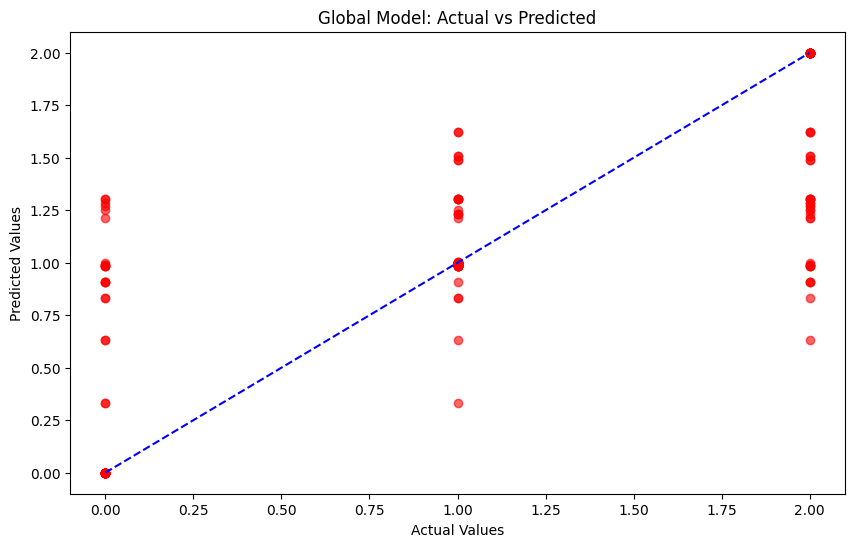

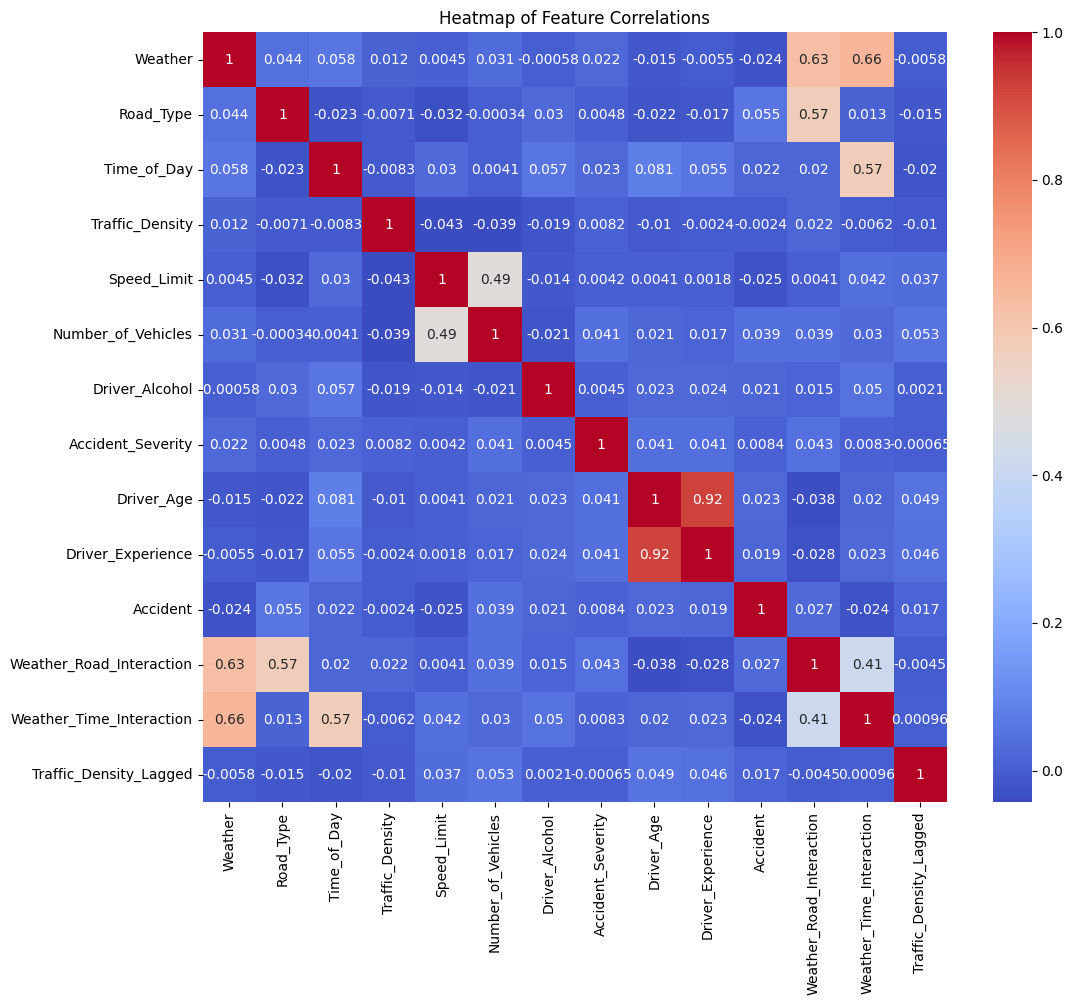

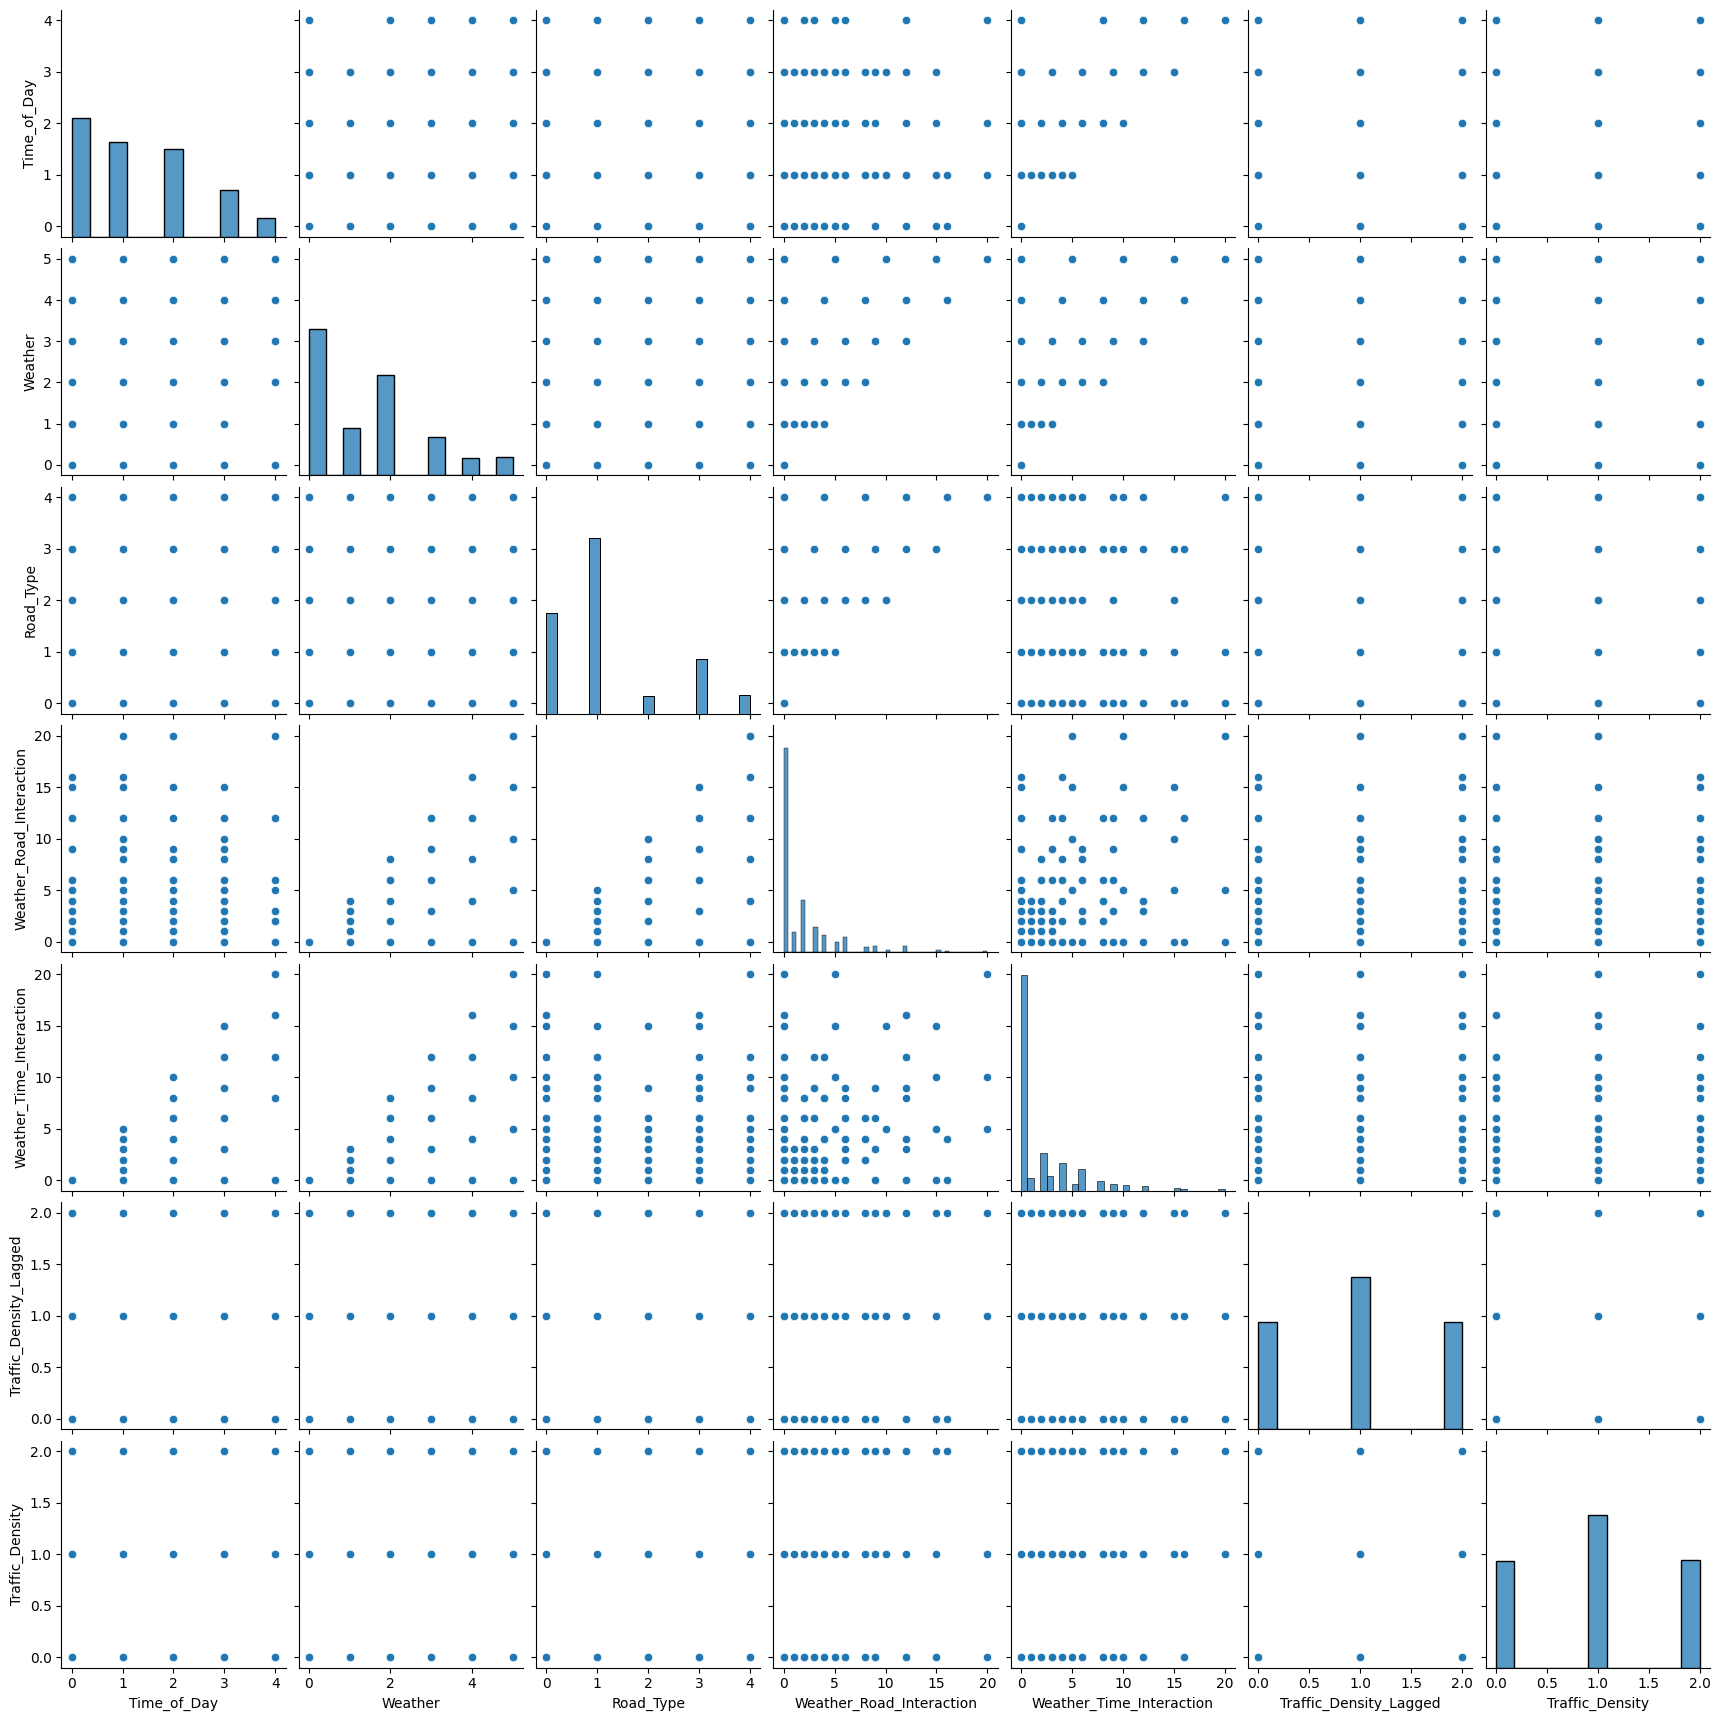

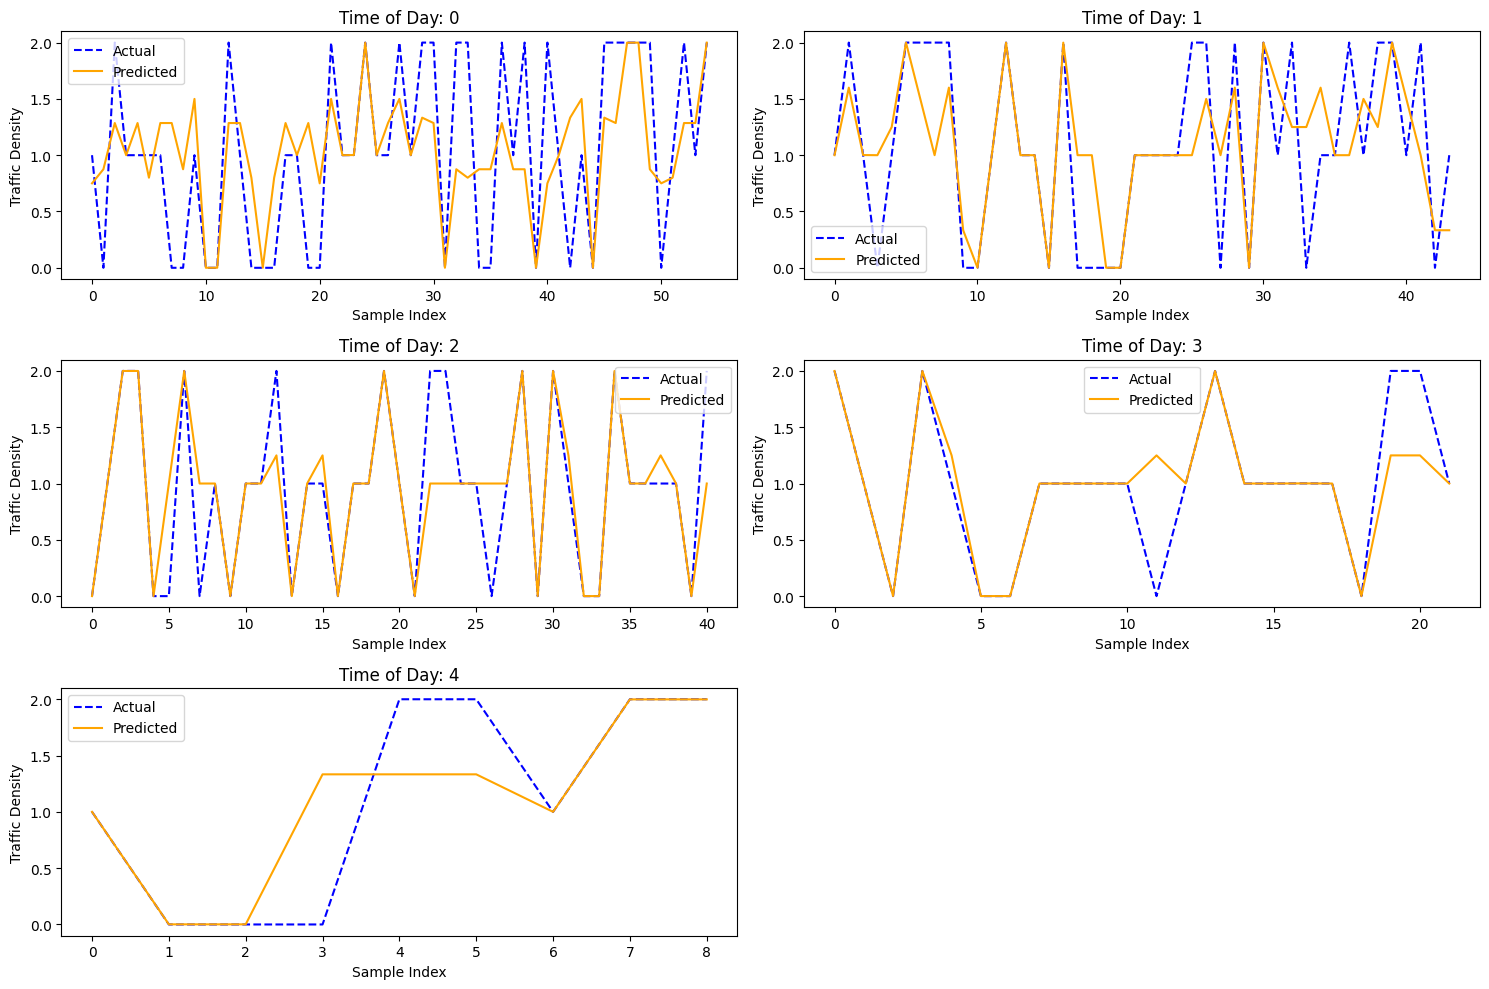

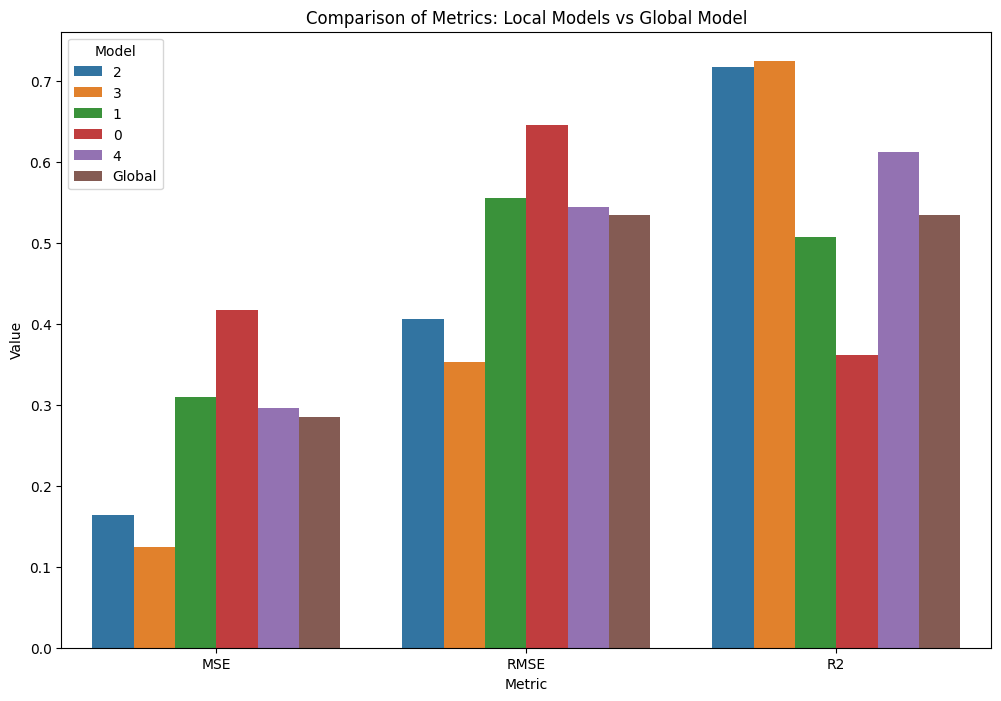

Results saved in: /Volumes/SP_SAGHAR/Documents/University/Articles/research_base/3- Traffic/figs/fig_GNN
Execution Time: 25.103567838668823 seconds
Global Model Metrics:
MSE: 0.2856365395423485, RMSE: 0.5344497539922238, R2: 0.5341702937575079


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import dgl
import torch
import torch.nn as nn
from dgl.nn import GraphConv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Record the start time
start_time = time.time()

# Load dataset
file_path = 'your ouwn path'
df = pd.read_csv(file_path)

# Preprocessing
# Encode categorical columns
label_encoders = {}
for column in ['Time_of_Day', 'Weather', 'Road_Type', 'Accident_Severity']:
    if column in df.columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Handle missing values only for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Feature engineering
# Adding interaction terms and lagged variables
if 'Weather' in df.columns and 'Road_Type' in df.columns:
    df['Weather_Road_Interaction'] = df['Weather'] * df['Road_Type']
if 'Weather' in df.columns and 'Time_of_Day' in df.columns:
    df['Weather_Time_Interaction'] = df['Weather'] * df['Time_of_Day']
if 'Traffic_Density' in df.columns:
    df['Traffic_Density_Lagged'] = df['Traffic_Density'].shift(1).fillna(df['Traffic_Density'].mean())

# Select top features
feature_columns = [
    'Time_of_Day', 'Weather', 'Road_Type', 'Weather_Road_Interaction',
    'Weather_Time_Interaction', 'Traffic_Density_Lagged'
]
feature_columns = [col for col in feature_columns if col in df.columns]
X = df[feature_columns]
Y = df['Traffic_Density'] if 'Traffic_Density' in df.columns else None
X_selected = SelectKBest(score_func=f_regression, k=min(5, len(feature_columns))).fit_transform(X, Y)

# GNN Integration
# Create graph structure
num_nodes = df.shape[0]
edges = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]
graph = dgl.graph(edges)

# Assign node features
graph.ndata['features'] = torch.tensor(X_selected, dtype=torch.float32)

# Define GNN model
class GNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, out_feats)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# Train GNN
in_feats = X_selected.shape[1]
hidden_feats = 16
out_feats = 1
gnn_model = GNN(in_feats, hidden_feats, out_feats)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

inputs = graph.ndata['features']
targets = torch.tensor(Y.values, dtype=torch.float32)

gnn_model.train()
for epoch in range(50):
    outputs = gnn_model(graph, inputs).squeeze()
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract GNN features
gnn_features = gnn_model(graph, inputs).detach().numpy()

# Combine GNN output with XGBoost local models
local_predictions = {}
local_metrics = []
all_local_results = []

for node_value in df['Time_of_Day'].unique():
    node_df = df[df['Time_of_Day'] == node_value]
    node_indices = node_df.index
    node_features = gnn_features[node_indices]

    xgb_model_1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_3 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model_4 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)

    X_train, X_test, Y_train, Y_test = train_test_split(node_features, node_df['Traffic_Density'], test_size=0.2)

    xgb_model_1.fit(X_train, Y_train)
    pred_1 = xgb_model_1.predict(X_test)
    xgb_model_2.fit(np.hstack((X_test, pred_1.reshape(-1, 1))), Y_test)
    pred_2 = xgb_model_2.predict(np.hstack((X_test, pred_1.reshape(-1, 1))))
    xgb_model_3.fit(np.hstack((X_test, pred_2.reshape(-1, 1))), Y_test)
    pred_3 = xgb_model_3.predict(np.hstack((X_test, pred_2.reshape(-1, 1))))
    xgb_model_4.fit(np.hstack((X_test, pred_3.reshape(-1, 1))), Y_test)
    pred_4 = xgb_model_4.predict(np.hstack((X_test, pred_3.reshape(-1, 1))))

    mse = mean_squared_error(Y_test, pred_4)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, pred_4)

    local_predictions[node_value] = (pred_4, Y_test)
    local_metrics.append({'Time_of_Day': node_value, 'MSE': mse, 'RMSE': rmse, 'R2': r2})

    for actual, predicted in zip(Y_test.values, pred_4):
        all_local_results.append({'Time_of_Day': node_value, 'Actual': actual, 'Predicted': predicted})

local_metrics_df = pd.DataFrame(local_metrics)

# Global Model
all_predictions = np.concatenate([pred[0] for pred in local_predictions.values()])
all_actuals = np.concatenate([actual for _, actual in local_predictions.values()])
global_model = RandomForestRegressor(n_estimators=100)
global_model.fit(all_predictions.reshape(-1, 1), all_actuals)
global_predictions = global_model.predict(all_predictions.reshape(-1, 1))

global_mse = mean_squared_error(all_actuals, global_predictions)
global_rmse = np.sqrt(global_mse)
global_r2 = r2_score(all_actuals, global_predictions)

# Save predictions and metrics to Excel and plots to the specified directory
output_dir = 'your ouwn path'
os.makedirs(output_dir, exist_ok=True)

excel_path = os.path.join(output_dir, 'model_predictions_and_metrics.xlsx')

with pd.ExcelWriter(excel_path) as writer:
    pd.DataFrame(all_local_results).to_excel(writer, sheet_name='Local Model Predictions', index=False)
    local_metrics_df.to_excel(writer, sheet_name='Local Model Metrics', index=False)
    pd.DataFrame({
        'Actual': all_actuals,
        'Predicted_Global': global_predictions
    }).to_excel(writer, sheet_name='Global Model Predictions', index=False)
    pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'R2'],
        'Global Model': [global_mse, global_rmse, global_r2]
    }).to_excel(writer, sheet_name='Global Model Metrics', index=False)

# GNN Predictions (Print in VS Code Environment)
print("\n=== GNN Predictions ===")
print(gnn_features)

# Local Model Predictions (Print in VS Code Environment)
print("\n=== Local Model Predictions ===")
for time_of_day, (predictions, actuals) in local_predictions.items():
    print(f"Time_of_Day: {time_of_day}")
    print("Predicted:", predictions)
    print("Actual:", actuals.values)

# Global Model Predictions (Print in VS Code Environment)
print("\n=== Global Model Predictions ===")
print("Actuals:", all_actuals)
print("Predicted:", global_predictions)

# Explanation of Nodes in GNN
print("\n=== Explanation of Nodes in GNN ===")
print("Each node represents a single sample (row) in the dataset. The edges connect nodes based on the defined relationships in the dataset.")

print(f"Results saved in: {output_dir}")

# Execution time
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print(f"Global Model Metrics:\nMSE: {global_mse}, RMSE: {global_rmse}, R2: {global_r2}")
